# Kundenmonitor 2023 Dataset Preprocessing and EDA (Exploratory Data Analysis)



In [1]:
import pandas as pd
import matplotlib.pyplot as plt

def flatten_survey_block(file_path, sheet_name, response_rows_keep, total_row_name):
    # Load Excel and sheet
    df = pd.read_excel(file_path, sheet_name=sheet_name, header=None)

    # Extract demographic labels
    demographic_type = df.iloc[2, 1:].ffill().astype(str).tolist()
    demographic_group = df.iloc[3, 1:].astype(str).tolist()
    demographic_labels = [f"{t.strip()}||{g.strip()}" for t, g in zip(demographic_type, demographic_group)]

    # Extract responses
    response_data = df.iloc[4:, :].copy()
    response_data.columns = ["Antwortoption"] + demographic_labels

    # Step 1: Extract the row with totals
    total_row = response_data[response_data["Antwortoption"] == total_row_name]
    total_dict = total_row.iloc[0, 1:].to_dict()  # column: value pairs
    total_dict = {k: float(v) if pd.notnull(v) else 0 for k, v in total_dict.items()}

    # Step 2: Keep only rows of interest
    response_data = response_data[response_data["Antwortoption"].isin(response_rows_keep)]

    # Step 3: Flatten to long format
    flat = response_data.melt(id_vars="Antwortoption", var_name="Demographic", value_name="Value (%)")
    flat["Question"] = df.iloc[1, 0]

    # Step 4: Split demographics into type/group
    split_demo = flat["Demographic"].dropna().apply(
        lambda x: x.split("||") if "||" in x and len(x.split("||")) == 2 else None
    )
    valid_indices = split_demo[split_demo.notnull()].index
    flat_valid = flat.loc[valid_indices].copy()
    flat_valid[["Demographic Type", "Demographic Group"]] = pd.DataFrame(
        split_demo.loc[valid_indices].tolist(), index=valid_indices
    )

    # Step 5: Clean and assign totals
    flat_valid["Value (%)"] = pd.to_numeric(flat_valid["Value (%)"], errors="coerce").fillna(0).round(1)

    # Map specific totals using the demographic label
    flat_valid["Total"] = flat_valid["Demographic"].map(total_dict).fillna(0).round(0).astype(int)

    # Step 6: Calculate counts
    flat_valid["Count"] = (flat_valid["Value (%)"] * flat_valid["Total"] / 100).round(0).astype(int)

    # Return final structure
    return flat_valid[["Question", "Demographic Type", "Demographic Group", "Antwortoption", "Value (%)", "Total", "Count"]]


In [2]:
flattened_table_q1 = flatten_survey_block(
    file_path="Kundenmonitor_Questions_Summary.xlsx",
    sheet_name="Kundenmonitor_Q1",
    response_rows_keep=[
        "Gesetzlich",
        "Privat"
    ],
    total_row_name="n gesamt (gewichtet)"
)

flattened_table_q1.head(5000)

,Question,Demographic Type,Demographic Group,Antwortoption,Value (%),Total,Count
0,Sind Sie gesetzlich oder privat krankenversich...,Geschlecht,Männlich,Gesetzlich,83.4,9879,8239
1,Sind Sie gesetzlich oder privat krankenversich...,Geschlecht,Männlich,Privat,15.8,9879,1561
2,Sind Sie gesetzlich oder privat krankenversich...,Geschlecht,Weiblich,Gesetzlich,91.4,10076,9209
3,Sind Sie gesetzlich oder privat krankenversich...,Geschlecht,Weiblich,Privat,8.2,10076,826
4,Sind Sie gesetzlich oder privat krankenversich...,Alter,16-29 Jahre,Gesetzlich,87.1,3640,3170
...,...,...,...,...,...,...,...
97,Sind Sie gesetzlich oder privat krankenversich...,Geld ist derzeit knapp,Voll und ganz,Privat,6.1,1728,105
98,Sind Sie gesetzlich oder privat krankenversich...,Geld ist derzeit knapp,Weitgehend,Gesetzlich,90.3,3078,2779
99,Sind Sie gesetzlich oder privat krankenversich...,Geld ist derzeit knapp,Weitgehend,Privat,9.2,3078,283
100,Sind Sie gesetzlich oder privat krankenversich...,Geld ist derzeit knapp,Eher nicht/überh. nicht,Gesetzlich,84.2,4809,4049


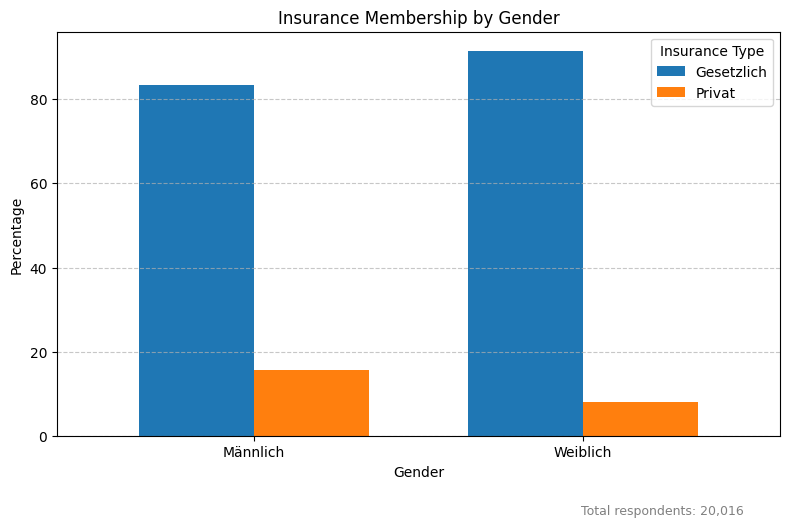

In [3]:
# Filter data
df_combined = flattened_table_q1[
    (flattened_table_q1["Antwortoption"].isin(["Gesetzlich", "Privat"])) &
    (flattened_table_q1["Demographic Type"] == "Geschlecht")
]

# Pivot so each row is a gender, and each column is an insurance type
df_pivot = df_combined.pivot(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)"
).sort_index()

# Plot
ax = df_pivot.plot(kind="bar", figsize=(8, 5), width=0.7)

plt.title("Insurance Membership by Gender")
plt.ylabel("Percentage")
plt.xlabel("Gender")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Insurance Type")
plt.tight_layout()

# Add annotation (adjust based on your total calculation)
plt.text(
    0.95,
    -0.20,
    "Total respondents: 20,016",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.show()

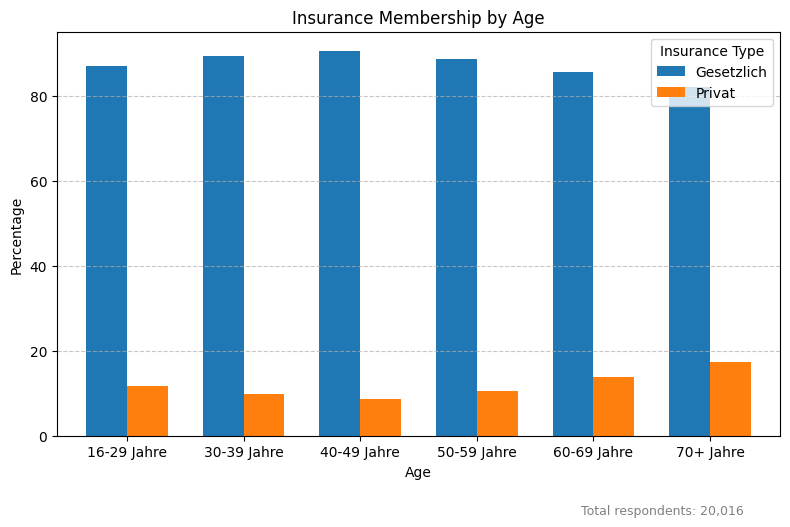

In [4]:
# Filter data
df_combined = flattened_table_q1[
    (flattened_table_q1["Antwortoption"].isin(["Gesetzlich", "Privat"])) &
    (flattened_table_q1["Demographic Type"] == "Alter")
]

# Pivot so each row is a gender, and each column is an insurance type
df_pivot = df_combined.pivot(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)"
).sort_index()

# Plot
ax = df_pivot.plot(kind="bar", figsize=(8, 5), width=0.7)

plt.title("Insurance Membership by Age")
plt.ylabel("Percentage")
plt.xlabel("Age")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Insurance Type")
plt.tight_layout()

# Add annotation (adjust based on your total calculation)
plt.text(
    0.95,
    -0.20,
    "Total respondents: 20,016",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.show()

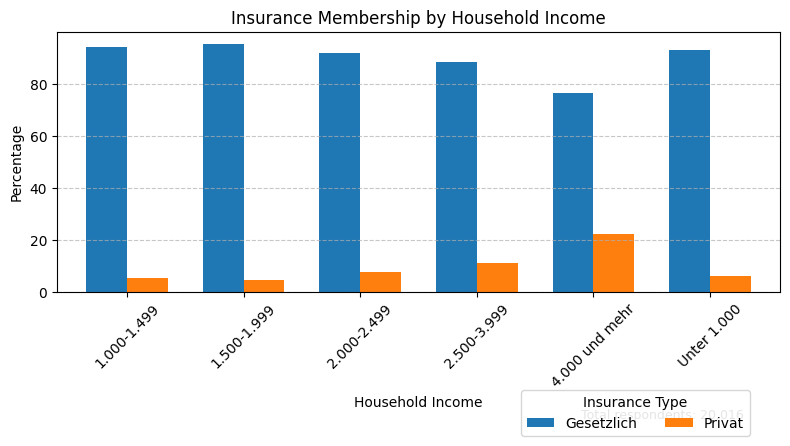

In [5]:
# Filter data
df_combined = flattened_table_q1[
    (flattened_table_q1["Antwortoption"].isin(["Gesetzlich", "Privat"])) &
    (flattened_table_q1["Demographic Type"] == "Haushaltsnettoeinkommen in Euro")
]

# Pivot so each row is a gender, and each column is an insurance type
df_pivot = df_combined.pivot(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)"
).sort_index()

# Plot
ax = df_pivot.plot(kind="bar", figsize=(8, 5), width=0.7)

plt.title("Insurance Membership by Household Income")
plt.ylabel("Percentage")
plt.xlabel("Household Income")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(
    title="Insurance Type",
    loc="upper center",
    bbox_to_anchor=(0.8, -0.35),
    ncol=2
)
plt.tight_layout()

# Add annotation (adjust based on your total calculation)
plt.text(
    0.95,
    -0.50,
    "Total respondents: 20,016",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.show()

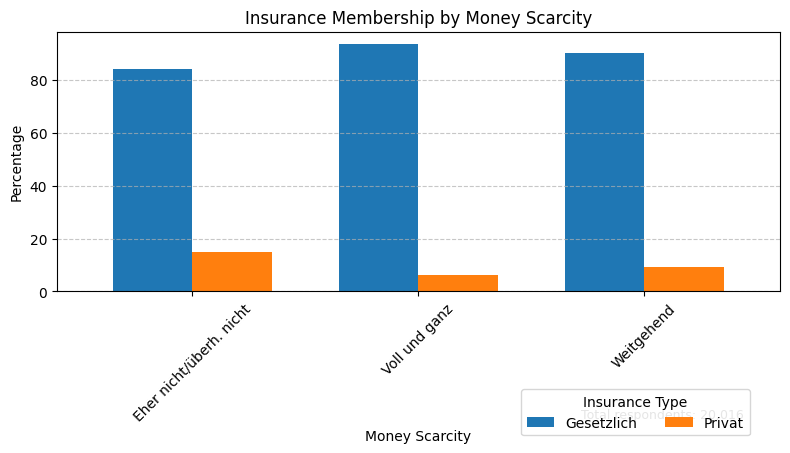

In [6]:
df_combined = flattened_table_q1[
    (flattened_table_q1["Antwortoption"].isin(["Gesetzlich", "Privat"])) &
    (flattened_table_q1["Demographic Type"] == "Geld ist derzeit knapp")
]

df_pivot = df_combined.pivot(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)"
).sort_index()

# Plot
ax = df_pivot.plot(kind="bar", figsize=(8, 5), width=0.7)

plt.title("Insurance Membership by Money Scarcity")
plt.ylabel("Percentage")
plt.xlabel("Money Scarcity")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(
    title="Insurance Type",
    loc="upper center",
    bbox_to_anchor=(0.8, -0.35),
    ncol=2
)
plt.tight_layout()

plt.text(
    0.95,
    -0.50,
    "Total respondents: 20,016",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.show()

In [8]:
flattened_table_q2 = flatten_survey_block(
    file_path="Kundenmonitor_Questions_Summary.xlsx",
    sheet_name="Kundenmonitor_Q2",
    response_rows_keep=[
        "AOK Baden-Württemberg",
        "AOK Bayern",
        "AOK Hessen",
        "AOK Niedersachsen",
        "AOK Nordost",
        "AOK Nordwest",
        "AOK Plus",
        "AOK Rheinland/Hamburg",
        "AOK Rheinland-Pfalz/Saarland",
        "AOK Sachsen-Anhalt",
        "Audi BKK",
        "Bahn-BKK",
        "Barmer",
        "Bergische Krankenkasse",
        "BIG direkt gesund",
        "BKK 24",
        "BKK Deutsche Bank AG",
        "BKK Euregio",
        "BKK Faber-Castell & Partner",
        "BKK firmus",
        "BKK Gildemeister Seidensticker",
        "BKK Linde",
        "BKK Pfalz",
        "BKK ProVita",
        "BKK Scheufelen",
        "BKK VBU",
        "BMW BKK",
        "Bosch BKK",
        "DAK-Gesundheit",
        "Debeka BKK",
        "Handelskrankenkasse (hkk)",
        "Heimat Krankenkasse",
        "HEK",
        "IKK Brandenburg und Berlin",
        "IKK classic",
        "IKK - Die Innovationskasse",
        "IKK gesund plus",
        "IKK Südwest",
        "KKH",
        "KNAPPSCHAFT",
        "Mercedes-Benz BKK",
        "mhplus BKK",
        "Mobil Krankenkasse",
        "Novitas BKK",
        "pronova BKK",
        "R+V BKK",
        "Salus BKK",
        "SBK",
        "Securvita",
        "TK",
        "VIACTIV Krankenkasse",
        "Vivida BKK",
        "Sonstige GKV"
    ],
    total_row_name="n gesamt (gewichtet)"
)

flattened_table_q2.head(5000)

,Question,Demographic Type,Demographic Group,Antwortoption,Value (%),Total,Count
0,Bei welcher gesetzlichen Krankenkasse sind Sie...,Gesamt,Gesamt,AOK Baden-Württemberg,4.9,17536,859
1,Bei welcher gesetzlichen Krankenkasse sind Sie...,Gesamt,Gesamt,AOK Bayern,4.7,17536,824
2,Bei welcher gesetzlichen Krankenkasse sind Sie...,Gesamt,Gesamt,AOK Hessen,1.4,17536,246
3,Bei welcher gesetzlichen Krankenkasse sind Sie...,Gesamt,Gesamt,AOK Niedersachsen,3.2,17536,561
4,Bei welcher gesetzlichen Krankenkasse sind Sie...,Gesamt,Gesamt,AOK Nordost,1.7,17536,298
...,...,...,...,...,...,...,...
3970,Bei welcher gesetzlichen Krankenkasse sind Sie...,Zusatzbeitrag,"> 1,6%",Securvita,0.0,3546,0
3971,Bei welcher gesetzlichen Krankenkasse sind Sie...,Zusatzbeitrag,"> 1,6%",TK,0.0,3546,0
3972,Bei welcher gesetzlichen Krankenkasse sind Sie...,Zusatzbeitrag,"> 1,6%",VIACTIV Krankenkasse,0.0,3546,0
3973,Bei welcher gesetzlichen Krankenkasse sind Sie...,Zusatzbeitrag,"> 1,6%",Vivida BKK,0.0,3546,0


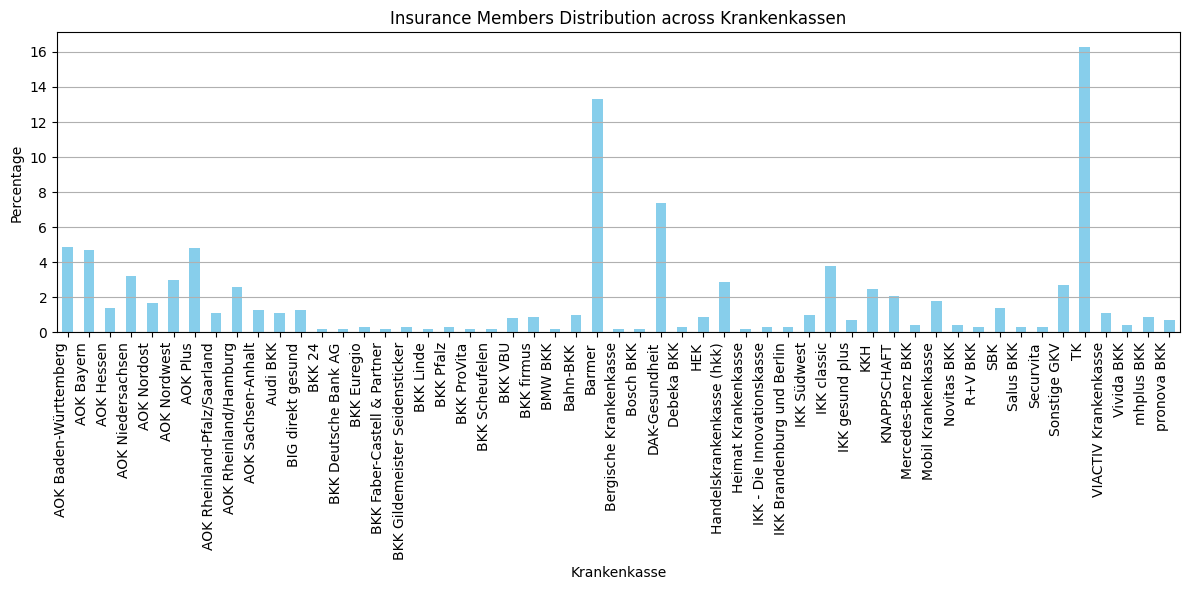

In [9]:
df_insurance_companies_distribution = flattened_table_q2[
    (flattened_table_q2["Antwortoption"].isin([
        "AOK Baden-Württemberg", "AOK Bayern", "AOK Hessen", "AOK Niedersachsen",
        "AOK Nordost", "AOK Nordwest", "AOK Plus", "AOK Rheinland/Hamburg",
        "AOK Rheinland-Pfalz/Saarland", "AOK Sachsen-Anhalt", "Audi BKK",
        "Bahn-BKK", "Barmer", "Bergische Krankenkasse", "BIG direkt gesund",
        "BKK 24", "BKK Deutsche Bank AG", "BKK Euregio", "BKK Faber-Castell & Partner",
        "BKK firmus", "BKK Gildemeister Seidensticker", "BKK Linde", "BKK Pfalz",
        "BKK ProVita", "BKK Scheufelen", "BKK VBU", "BMW BKK", "Bosch BKK",
        "DAK-Gesundheit", "Debeka BKK", "Handelskrankenkasse (hkk)", "Heimat Krankenkasse",
        "HEK", "IKK Brandenburg und Berlin", "IKK classic", "IKK - Die Innovationskasse",
        "IKK gesund plus", "IKK Südwest", "KKH", "KNAPPSCHAFT", "Mercedes-Benz BKK",
        "mhplus BKK", "Mobil Krankenkasse", "Novitas BKK", "pronova BKK", "R+V BKK",
        "Salus BKK", "SBK", "Securvita", "TK", "VIACTIV Krankenkasse", "Vivida BKK", "Sonstige GKV"
    ])) &
    (flattened_table_q2["Demographic Type"] == "Gesamt")
]

# Sort for consistent order
df_insurance_companies_distribution = df_insurance_companies_distribution.sort_values(by="Antwortoption")

# Set the Krankenkasse name as x-axis
df_insurance_companies_distribution.set_index("Antwortoption")["Value (%)"].plot(
    kind="bar", figsize=(12, 6), color="skyblue"
)

# Pivot for easy comparison
df_insurance_companies_distribution_pivot = df_insurance_companies_distribution.pivot(index="Demographic Group", columns="Antwortoption", values="Value (%)")
df_insurance_companies_distribution_pivot.sort_index()

plt.title("Insurance Members Distribution across Krankenkassen")
plt.ylabel("Percentage")
plt.xlabel("Krankenkasse")
plt.xticks(rotation=90, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


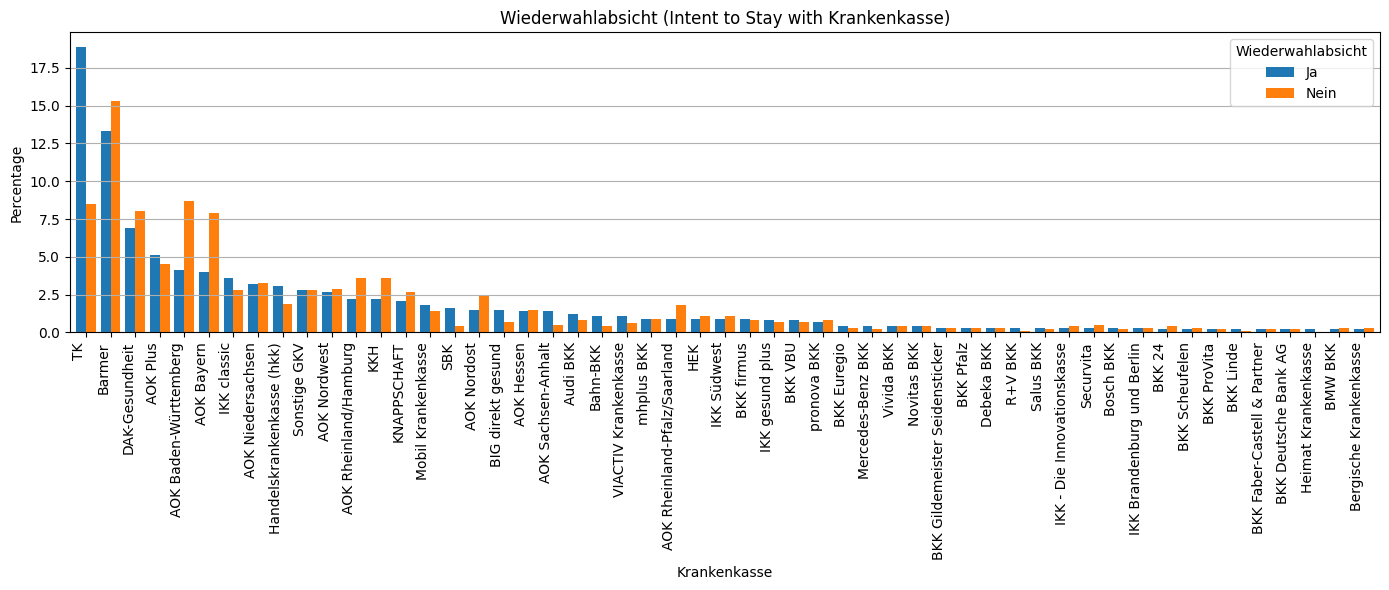

In [10]:
df = flattened_table_q2[
    (flattened_table_q2["Antwortoption"].isin([
        "AOK Baden-Württemberg", "AOK Bayern", "AOK Hessen", "AOK Niedersachsen",
        "AOK Nordost", "AOK Nordwest", "AOK Plus", "AOK Rheinland/Hamburg",
        "AOK Rheinland-Pfalz/Saarland", "AOK Sachsen-Anhalt", "Audi BKK",
        "Bahn-BKK", "Barmer", "Bergische Krankenkasse", "BIG direkt gesund",
        "BKK 24", "BKK Deutsche Bank AG", "BKK Euregio", "BKK Faber-Castell & Partner",
        "BKK firmus", "BKK Gildemeister Seidensticker", "BKK Linde", "BKK Pfalz",
        "BKK ProVita", "BKK Scheufelen", "BKK VBU", "BMW BKK", "Bosch BKK",
        "DAK-Gesundheit", "Debeka BKK", "Handelskrankenkasse (hkk)", "Heimat Krankenkasse",
        "HEK", "IKK Brandenburg und Berlin", "IKK classic", "IKK - Die Innovationskasse",
        "IKK gesund plus", "IKK Südwest", "KKH", "KNAPPSCHAFT", "Mercedes-Benz BKK",
        "mhplus BKK", "Mobil Krankenkasse", "Novitas BKK", "pronova BKK", "R+V BKK",
        "Salus BKK", "SBK", "Securvita", "TK", "VIACTIV Krankenkasse", "Vivida BKK", "Sonstige GKV"
    ])) &
    (flattened_table_q2["Demographic Type"] == "Wiederwahlabsicht") &
    (~flattened_table_q2["Demographic Group"].str.lower().str.contains("evtl"))
].copy()

# Step 2: Pivot on "Antwortoption" as rows, "Demographic Group" (Ja/Nein) as columns
pivot_df = df.pivot(index="Antwortoption", columns="Demographic Group", values="Value (%)")

# Optional: Sort by 'Ja' for clarity
pivot_df = pivot_df.sort_values(by="Ja", ascending=False)

# Step 3: Plot as grouped bar chart
pivot_df.plot(kind="bar", figsize=(14, 6), width=0.8)
plt.title("Wiederwahlabsicht (Intent to Stay with Krankenkasse)")
plt.xlabel("Krankenkasse")
plt.ylabel("Percentage")
plt.xticks(rotation=90, ha="right")
plt.legend(title="Wiederwahlabsicht")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

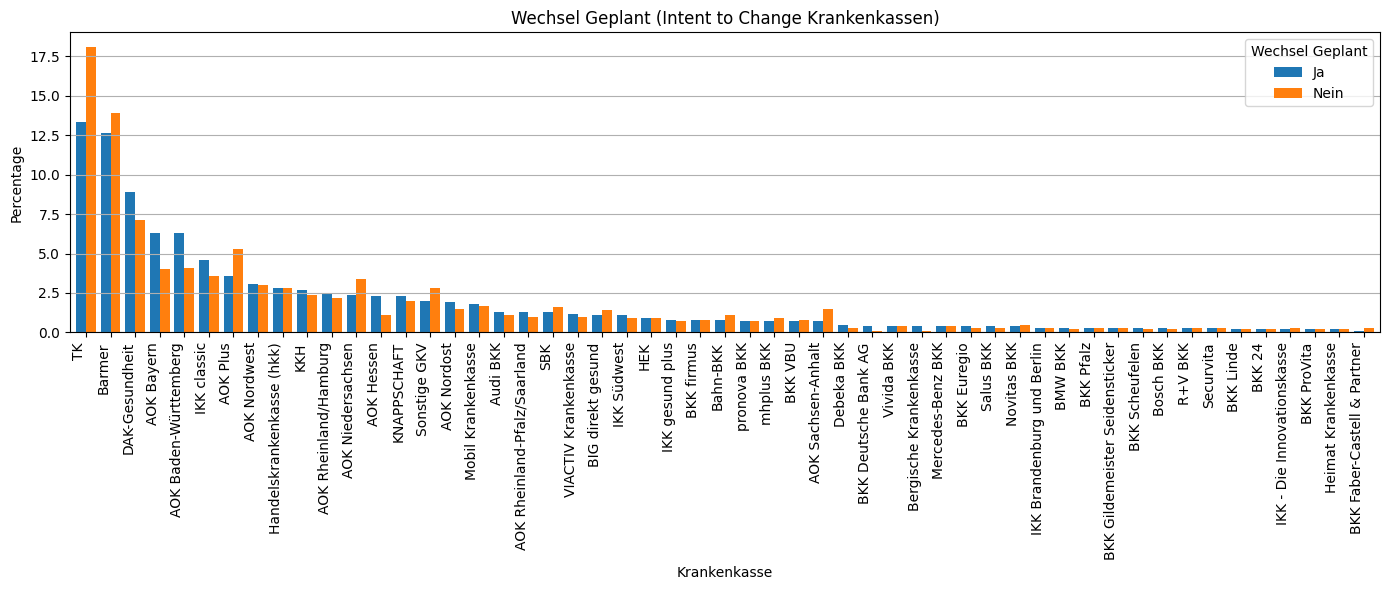

In [11]:
df = flattened_table_q2[
    (flattened_table_q2["Antwortoption"].isin([
        "AOK Baden-Württemberg", "AOK Bayern", "AOK Hessen", "AOK Niedersachsen",
        "AOK Nordost", "AOK Nordwest", "AOK Plus", "AOK Rheinland/Hamburg",
        "AOK Rheinland-Pfalz/Saarland", "AOK Sachsen-Anhalt", "Audi BKK",
        "Bahn-BKK", "Barmer", "Bergische Krankenkasse", "BIG direkt gesund",
        "BKK 24", "BKK Deutsche Bank AG", "BKK Euregio", "BKK Faber-Castell & Partner",
        "BKK firmus", "BKK Gildemeister Seidensticker", "BKK Linde", "BKK Pfalz",
        "BKK ProVita", "BKK Scheufelen", "BKK VBU", "BMW BKK", "Bosch BKK",
        "DAK-Gesundheit", "Debeka BKK", "Handelskrankenkasse (hkk)", "Heimat Krankenkasse",
        "HEK", "IKK Brandenburg und Berlin", "IKK classic", "IKK - Die Innovationskasse",
        "IKK gesund plus", "IKK Südwest", "KKH", "KNAPPSCHAFT", "Mercedes-Benz BKK",
        "mhplus BKK", "Mobil Krankenkasse", "Novitas BKK", "pronova BKK", "R+V BKK",
        "Salus BKK", "SBK", "Securvita", "TK", "VIACTIV Krankenkasse", "Vivida BKK", "Sonstige GKV"
    ])) &
    (flattened_table_q2["Demographic Type"] == "Wechsel geplant") &
    (~flattened_table_q2["Demographic Group"].str.lower().str.contains("evtl"))
].copy()

# Step 2: Pivot on "Antwortoption" as rows, "Demographic Group" (Ja/Nein) as columns
pivot_df = df.pivot(index="Antwortoption", columns="Demographic Group", values="Value (%)")

# Optional: Sort by 'Ja' for clarity
pivot_df = pivot_df.sort_values(by="Ja", ascending=False)

# Step 3: Plot as grouped bar chart
pivot_df.plot(kind="bar", figsize=(14, 6), width=0.8)
plt.title("Wechsel Geplant (Intent to Change Krankenkassen)")
plt.xlabel("Krankenkasse")
plt.ylabel("Percentage")
plt.xticks(rotation=90, ha="right")
plt.legend(title="Wechsel Geplant")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


In [12]:
flattened_table_q3 = flatten_survey_block(
    file_path="Kundenmonitor_Questions_Summary.xlsx",
    sheet_name="Kundenmonitor_Q3",
    response_rows_keep=[
        "Selbst Mitglied der Krankenkasse",
        "Als Familienangehöriger mitversichert"
    ],
    total_row_name="n gültig (Basis, gewichtet)"
)

flattened_table_q3.head(5000)

,Question,Demographic Type,Demographic Group,Antwortoption,Value (%),Total,Count
0,Sind Sie Sie selbst Mitglied Ihrer Krankenkass...,Geschlecht,Männlich,Selbst Mitglied der Krankenkasse,92.3,8082,7460
1,Sind Sie Sie selbst Mitglied Ihrer Krankenkass...,Geschlecht,Männlich,Als Familienangehöriger mitversichert,7.7,8082,622
2,Sind Sie Sie selbst Mitglied Ihrer Krankenkass...,Geschlecht,Weiblich,Selbst Mitglied der Krankenkasse,85.4,9226,7879
3,Sind Sie Sie selbst Mitglied Ihrer Krankenkass...,Geschlecht,Weiblich,Als Familienangehöriger mitversichert,14.6,9226,1347
4,Sind Sie Sie selbst Mitglied Ihrer Krankenkass...,Alter,16-29 Jahre,Selbst Mitglied der Krankenkasse,67.0,3090,2070
...,...,...,...,...,...,...,...
247,Sind Sie Sie selbst Mitglied Ihrer Krankenkass...,Zusatzbeitrag,"textless 1,6%",Als Familienangehöriger mitversichert,10.7,11104,1188
248,Sind Sie Sie selbst Mitglied Ihrer Krankenkass...,Zusatzbeitrag,"1,6%",Selbst Mitglied der Krankenkasse,87.3,2556,2231
249,Sind Sie Sie selbst Mitglied Ihrer Krankenkass...,Zusatzbeitrag,"1,6%",Als Familienangehöriger mitversichert,12.7,2556,325
250,Sind Sie Sie selbst Mitglied Ihrer Krankenkass...,Zusatzbeitrag,"> 1,6%",Selbst Mitglied der Krankenkasse,87.9,3525,3098


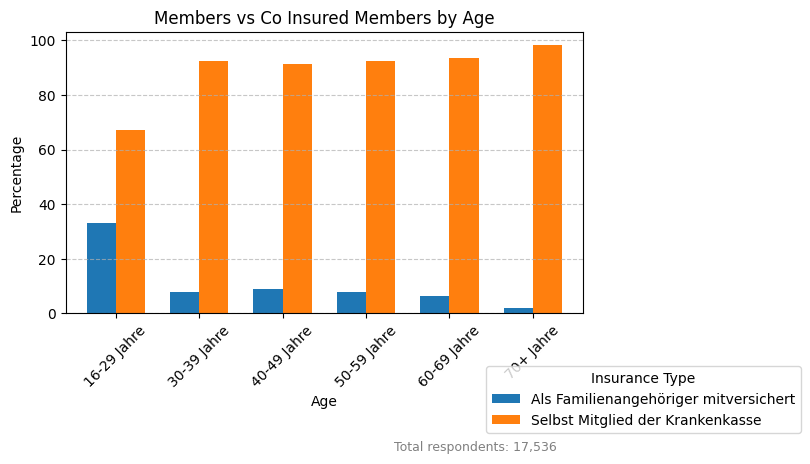

In [26]:
df_combined = flattened_table_q3[
    (flattened_table_q3["Antwortoption"].isin(["Selbst Mitglied der Krankenkasse", "Als Familienangehöriger mitversichert"])) &
    (flattened_table_q3["Demographic Type"] == "Alter")
]

df_pivot = df_combined.pivot(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)"
).sort_index()

# Plot
ax = df_pivot.plot(kind="bar", figsize=(8, 5), width=0.7)

plt.title("Members vs Co Insured Members by Age")
plt.ylabel("Percentage")
plt.xlabel("Age")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(
    title="Insurance Type",
    loc="lower left",
    bbox_to_anchor=(0.8, -0.45),
    # ncol=2
)
plt.tight_layout()

plt.text(
    0.95,
    -0.50,
    "Total respondents: 17,536",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.show()

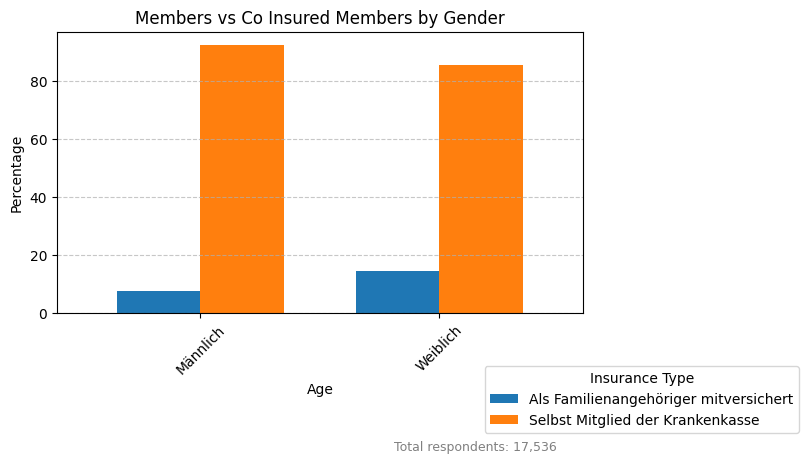

In [28]:
df_combined = flattened_table_q3[
    (flattened_table_q3["Antwortoption"].isin(["Selbst Mitglied der Krankenkasse", "Als Familienangehöriger mitversichert"])) &
    (flattened_table_q3["Demographic Type"] == "Geschlecht")
]

df_pivot = df_combined.pivot(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)"
).sort_index()

# Plot
ax = df_pivot.plot(kind="bar", figsize=(8, 5), width=0.7)

plt.title("Members vs Co Insured Members by Gender")
plt.ylabel("Percentage")
plt.xlabel("Age")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(
    title="Insurance Type",
    loc="lower left",
    bbox_to_anchor=(0.8, -0.45),
    # ncol=2
)
plt.tight_layout()

plt.text(
    0.95,
    -0.50,
    "Total respondents: 17,536",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.show()

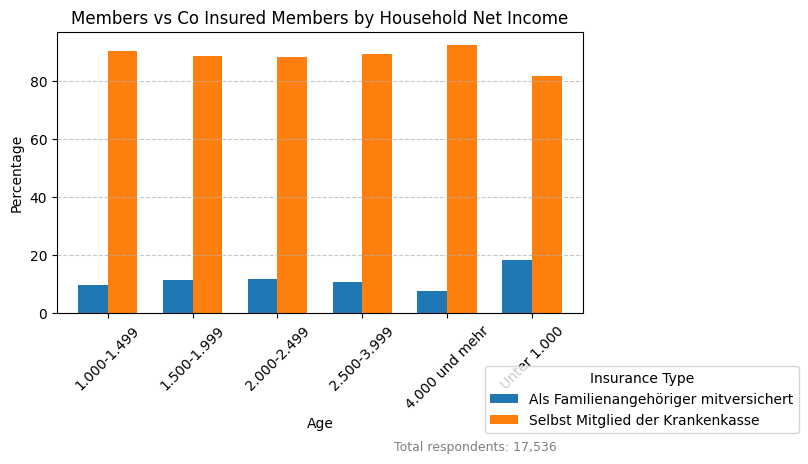

In [29]:
df_combined = flattened_table_q3[
    (flattened_table_q3["Antwortoption"].isin(["Selbst Mitglied der Krankenkasse", "Als Familienangehöriger mitversichert"])) &
    (flattened_table_q3["Demographic Type"] == "Haushaltsnettoeinkommen in Euro")
]

df_pivot = df_combined.pivot(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)"
).sort_index()

# Plot
ax = df_pivot.plot(kind="bar", figsize=(8, 5), width=0.7)

plt.title("Members vs Co Insured Members by Household Net Income")
plt.ylabel("Percentage")
plt.xlabel("Age")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(
    title="Insurance Type",
    loc="lower left",
    bbox_to_anchor=(0.8, -0.45),
    # ncol=2
)
plt.tight_layout()

plt.text(
    0.95,
    -0.50,
    "Total respondents: 17,536",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.show()

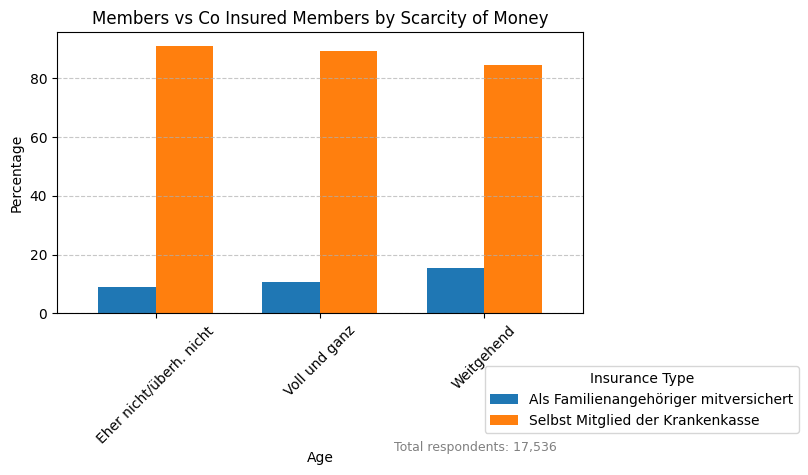

In [30]:
df_combined = flattened_table_q3[
    (flattened_table_q3["Antwortoption"].isin(["Selbst Mitglied der Krankenkasse", "Als Familienangehöriger mitversichert"])) &
    (flattened_table_q3["Demographic Type"] == "Geld ist derzeit knapp")
]

df_pivot = df_combined.pivot(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)"
).sort_index()

# Plot
ax = df_pivot.plot(kind="bar", figsize=(8, 5), width=0.7)

plt.title("Members vs Co Insured Members by Scarcity of Money")
plt.ylabel("Percentage")
plt.xlabel("Age")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(
    title="Insurance Type",
    loc="lower left",
    bbox_to_anchor=(0.8, -0.45),
    # ncol=2
)
plt.tight_layout()

plt.text(
    0.95,
    -0.50,
    "Total respondents: 17,536",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.show()

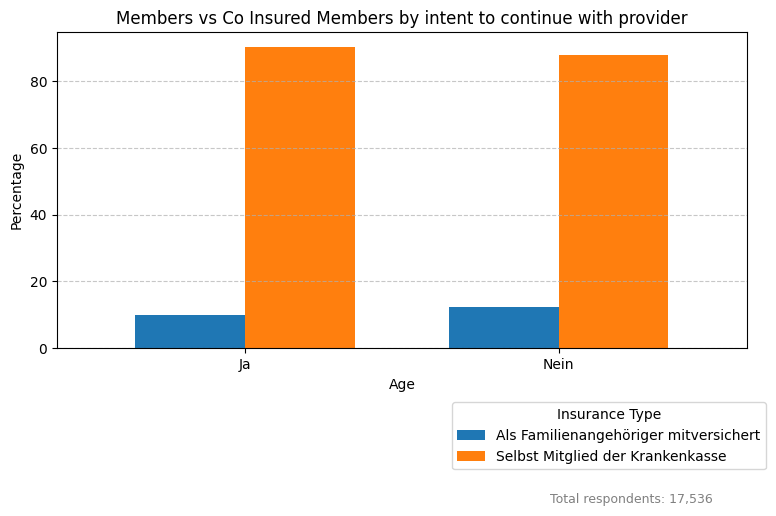

In [32]:
df_combined = flattened_table_q3[
    (flattened_table_q3["Antwortoption"].isin(["Selbst Mitglied der Krankenkasse", "Als Familienangehöriger mitversichert"])) &
    (flattened_table_q3["Demographic Type"] == "Wiederwahlabsicht") &
    (~flattened_table_q3["Demographic Group"].str.lower().str.contains("evtl"))
]

df_pivot = df_combined.pivot(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)"
).sort_index()

# Plot
ax = df_pivot.plot(kind="bar", figsize=(8, 5), width=0.7)

plt.title("Members vs Co Insured Members by intent to continue with provider")
plt.ylabel("Percentage")
plt.xlabel("Age")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(
    title="Insurance Type",
    loc="upper center",
    bbox_to_anchor=(0.8, -0.15)
)
plt.tight_layout()

plt.text(
    0.95,
    -0.50,
    "Total respondents: 17,536",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.show()

In [33]:
flattened_table_q4 = flatten_survey_block(
    file_path="Kundenmonitor_Questions_Summary.xlsx",
    sheet_name="Kundenmonitor_Q4",
    response_rows_keep=[
        "Vollkommen zufrieden (1)",
        "Sehr zufrieden (2)",
        "Zufrieden (3)",
        "Weniger zufrieden (4)",
        "Unzufrieden (5)"
    ],
    total_row_name="n gültig (Basis, gewichtet)"
)

flattened_table_q4.head(5000)

,Question,Demographic Type,Demographic Group,Antwortoption,Value (%),Total,Count
0,Wie zufrieden sind Sie mit Ihrer Krankenkasse/...,Geschlecht,Männlich,Vollkommen zufrieden (1),26.4,8092,2136
1,Wie zufrieden sind Sie mit Ihrer Krankenkasse/...,Geschlecht,Männlich,Sehr zufrieden (2),37.9,8092,3067
2,Wie zufrieden sind Sie mit Ihrer Krankenkasse/...,Geschlecht,Männlich,Zufrieden (3),29.7,8092,2403
3,Wie zufrieden sind Sie mit Ihrer Krankenkasse/...,Geschlecht,Männlich,Weniger zufrieden (4),4.1,8092,332
4,Wie zufrieden sind Sie mit Ihrer Krankenkasse/...,Geschlecht,Männlich,Unzufrieden (5),1.9,8092,154
...,...,...,...,...,...,...,...
395,Wie zufrieden sind Sie mit Ihrer Krankenkasse/...,Zusatzbeitrag,"> 1,6%",Vollkommen zufrieden (1),23.4,3518,823
396,Wie zufrieden sind Sie mit Ihrer Krankenkasse/...,Zusatzbeitrag,"> 1,6%",Sehr zufrieden (2),34.3,3518,1207
397,Wie zufrieden sind Sie mit Ihrer Krankenkasse/...,Zusatzbeitrag,"> 1,6%",Zufrieden (3),35.4,3518,1245
398,Wie zufrieden sind Sie mit Ihrer Krankenkasse/...,Zusatzbeitrag,"> 1,6%",Weniger zufrieden (4),5.2,3518,183


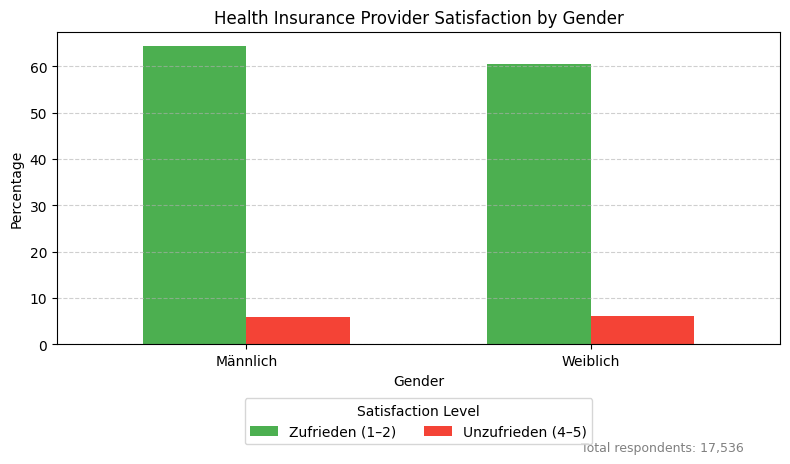

In [39]:
df_filtered = flattened_table_q4[
    (flattened_table_q4["Antwortoption"].isin([
        "Vollkommen zufrieden (1)",
        "Sehr zufrieden (2)",
        "Zufrieden (3)",
        "Weniger zufrieden (4)",
        "Unzufrieden (5)"
    ])) &
    (flattened_table_q4["Demographic Type"] == "Geschlecht") &
    (~flattened_table_q4["Demographic Group"].str.lower().str.contains("evtl"))
]

# Step 2: Pivot and clean
df_pivot_raw = df_filtered.pivot_table(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)",
    aggfunc="first"
).fillna(0)

# Step 3: Combine relevant columns
df_combined = pd.DataFrame()
df_combined["Zufrieden (1–2)"] = df_pivot_raw["Vollkommen zufrieden (1)"] + df_pivot_raw["Sehr zufrieden (2)"]
df_combined["Unzufrieden (4–5)"] = df_pivot_raw["Weniger zufrieden (4)"] + df_pivot_raw["Unzufrieden (5)"]

# Step 4: Plot
ax = df_combined.plot(kind="bar", figsize=(8, 5), width=0.6, color=["#4CAF50", "#F44336"])

plt.title("Health Insurance Provider Satisfaction by Gender")
plt.ylabel("Percentage")
plt.xlabel("Gender")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.legend(
    title="Satisfaction Level",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2
)

plt.text(
    0.95, -0.35,
    "Total respondents: 17,536",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.tight_layout()
plt.show()

# Those that have a good satisfaction level and want to continue
# Those that have a bad satisfaction level and want to continue
# Those that have a good satisfaction level and do not want to continue
# Those that have a bad satisfaction level and do not want to continue

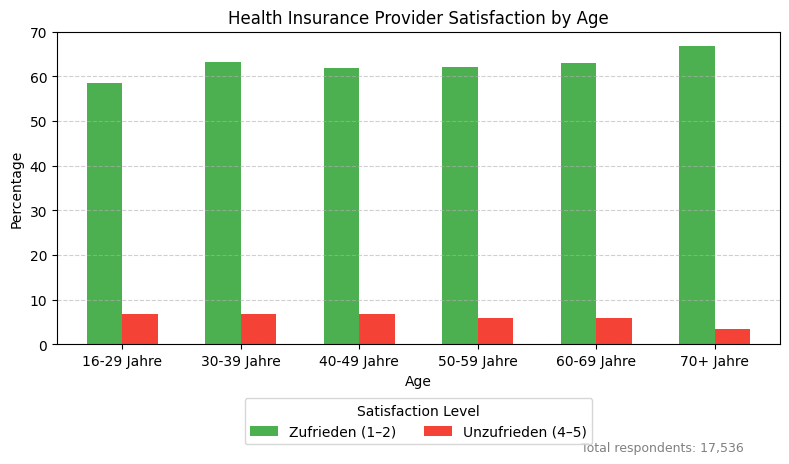

In [40]:
df_filtered = flattened_table_q4[
    (flattened_table_q4["Antwortoption"].isin([
        "Vollkommen zufrieden (1)",
        "Sehr zufrieden (2)",
        "Zufrieden (3)",
        "Weniger zufrieden (4)",
        "Unzufrieden (5)"
    ])) &
    (flattened_table_q4["Demographic Type"] == "Alter") &
    (~flattened_table_q4["Demographic Group"].str.lower().str.contains("evtl"))
]

# Step 2: Pivot and clean
df_pivot_raw = df_filtered.pivot_table(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)",
    aggfunc="first"
).fillna(0)

# Step 3: Combine relevant columns
df_combined = pd.DataFrame()
df_combined["Zufrieden (1–2)"] = df_pivot_raw["Vollkommen zufrieden (1)"] + df_pivot_raw["Sehr zufrieden (2)"]
df_combined["Unzufrieden (4–5)"] = df_pivot_raw["Weniger zufrieden (4)"] + df_pivot_raw["Unzufrieden (5)"]

# Step 4: Plot
ax = df_combined.plot(kind="bar", figsize=(8, 5), width=0.6, color=["#4CAF50", "#F44336"])

plt.title("Health Insurance Provider Satisfaction by Age")
plt.ylabel("Percentage")
plt.xlabel("Age")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.legend(
    title="Satisfaction Level",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2
)

plt.text(
    0.95, -0.35,
    "Total respondents: 17,536",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.tight_layout()
plt.show()

# Those that have a good satisfaction level and want to continue
# Those that have a bad satisfaction level and want to continue
# Those that have a good satisfaction level and do not want to continue
# Those that have a bad satisfaction level and do not want to continue

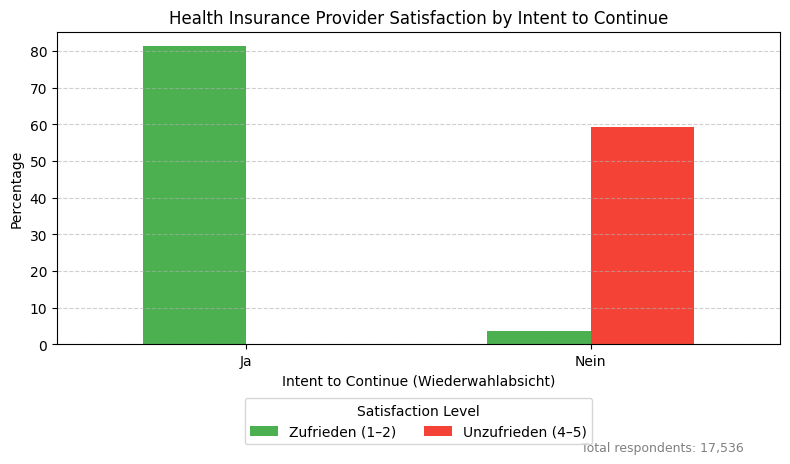

In [41]:
df_filtered = flattened_table_q4[
    (flattened_table_q4["Antwortoption"].isin([
        "Vollkommen zufrieden (1)",
        "Sehr zufrieden (2)",
        "Zufrieden (3)",
        "Weniger zufrieden (4)",
        "Unzufrieden (5)"
    ])) &
    (flattened_table_q4["Demographic Type"] == "Wiederwahlabsicht") &
    (~flattened_table_q4["Demographic Group"].str.lower().str.contains("evtl"))
]

# Step 2: Pivot and clean
df_pivot_raw = df_filtered.pivot_table(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)",
    aggfunc="first"
).fillna(0)

# Step 3: Combine relevant columns
df_combined = pd.DataFrame()
df_combined["Zufrieden (1–2)"] = df_pivot_raw["Vollkommen zufrieden (1)"] + df_pivot_raw["Sehr zufrieden (2)"]
df_combined["Unzufrieden (4–5)"] = df_pivot_raw["Weniger zufrieden (4)"] + df_pivot_raw["Unzufrieden (5)"]

# Step 4: Plot
ax = df_combined.plot(kind="bar", figsize=(8, 5), width=0.6, color=["#4CAF50", "#F44336"])

plt.title("Health Insurance Provider Satisfaction by Intent to Continue")
plt.ylabel("Percentage")
plt.xlabel("Intent to Continue (Wiederwahlabsicht)")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.legend(
    title="Satisfaction Level",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2
)

plt.text(
    0.95, -0.35,
    "Total respondents: 17,536",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.tight_layout()
plt.show()

# Those that have a good satisfaction level and want to continue
# Those that have a bad satisfaction level and want to continue
# Those that have a good satisfaction level and do not want to continue
# Those that have a bad satisfaction level and do not want to continue

In [45]:
flattened_table_q4 = flatten_survey_block(
    file_path="Kundenmonitor_Questions_Summary.xlsx",
    sheet_name="Kundenmonitor_Q7",
    response_rows_keep=[
        "Ja",
        "Nein"
    ],
    total_row_name="n gesamt (gewichtet)"
)

flattened_table_q4.head(5000)

,Question,Demographic Type,Demographic Group,Antwortoption,Value (%),Total,Count
0,Geplanter Wechsel der Krankenkasse,Geschlecht,Männlich,Ja,25.6,8112,2077
1,Geplanter Wechsel der Krankenkasse,Geschlecht,Männlich,Nein,64.8,8112,5257
2,Geplanter Wechsel der Krankenkasse,Geschlecht,Weiblich,Ja,19.7,9270,1826
3,Geplanter Wechsel der Krankenkasse,Geschlecht,Weiblich,Nein,69.0,9270,6396
4,Geplanter Wechsel der Krankenkasse,Alter,16-29 Jahre,Ja,30.1,3128,942
...,...,...,...,...,...,...,...
143,Geplanter Wechsel der Krankenkasse,Zusatzbeitrag,"textless 1,6%",Nein,69.7,11145,7768
144,Geplanter Wechsel der Krankenkasse,Zusatzbeitrag,"1,6%",Ja,28.2,2566,724
145,Geplanter Wechsel der Krankenkasse,Zusatzbeitrag,"1,6%",Nein,59.5,2566,1527
146,Geplanter Wechsel der Krankenkasse,Zusatzbeitrag,"> 1,6%",Ja,24.4,3537,863


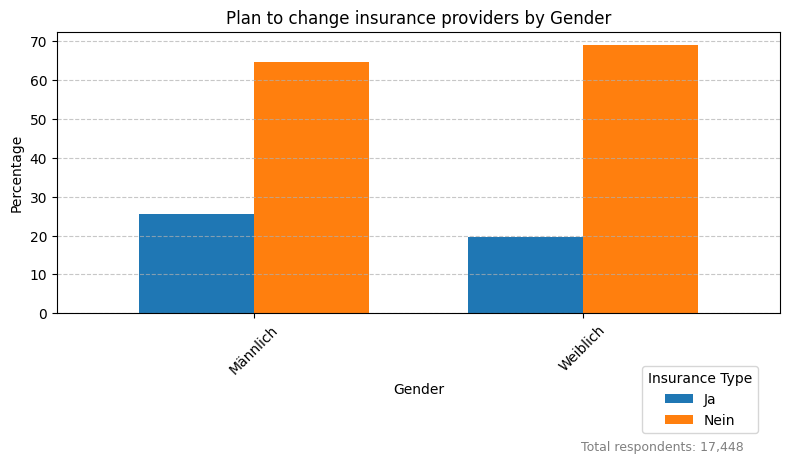

In [49]:
df_combined = flattened_table_q4[
    (flattened_table_q4["Antwortoption"].isin(["Ja", "Nein"])) &
    (flattened_table_q4["Demographic Type"] == "Geschlecht")
]

df_pivot = df_combined.pivot(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)"
).sort_index()

# Plot
ax = df_pivot.plot(kind="bar", figsize=(8, 5), width=0.7)

plt.title("Plan to change insurance providers by Gender")
plt.ylabel("Percentage")
plt.xlabel("Gender")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(
    title="Insurance Type",
    loc="lower left",
    bbox_to_anchor=(0.8, -0.45),
    # ncol=2
)
plt.tight_layout()

plt.text(
    0.95,
    -0.50,
    "Total respondents: 17,448",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.show()

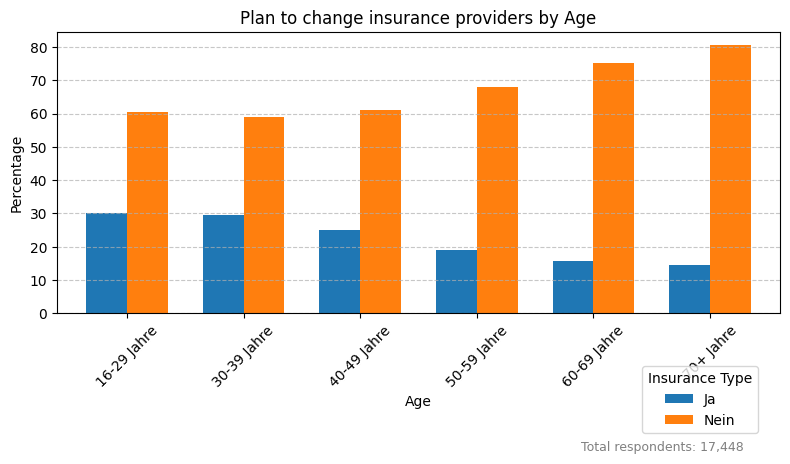

In [50]:
df_combined = flattened_table_q4[
    (flattened_table_q4["Antwortoption"].isin(["Ja", "Nein"])) &
    (flattened_table_q4["Demographic Type"] == "Alter")
]

df_pivot = df_combined.pivot(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)"
).sort_index()

# Plot
ax = df_pivot.plot(kind="bar", figsize=(8, 5), width=0.7)

plt.title("Plan to change insurance providers by Age")
plt.ylabel("Percentage")
plt.xlabel("Age")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(
    title="Insurance Type",
    loc="lower left",
    bbox_to_anchor=(0.8, -0.45),
    # ncol=2
)
plt.tight_layout()

plt.text(
    0.95,
    -0.50,
    "Total respondents: 17,448",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.show()

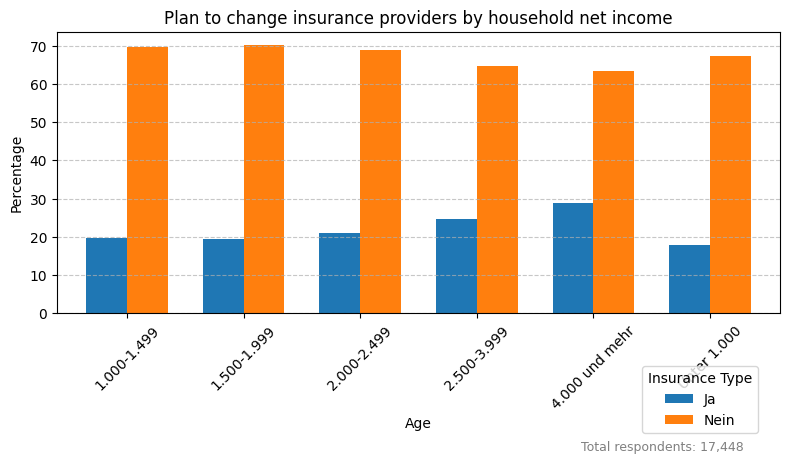

In [51]:
df_combined = flattened_table_q4[
    (flattened_table_q4["Antwortoption"].isin(["Ja", "Nein"])) &
    (flattened_table_q4["Demographic Type"] == "Haushaltsnettoeinkommen in Euro")
]

df_pivot = df_combined.pivot(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)"
).sort_index()

# Plot
ax = df_pivot.plot(kind="bar", figsize=(8, 5), width=0.7)

plt.title("Plan to change insurance providers by household net income")
plt.ylabel("Percentage")
plt.xlabel("Age")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(
    title="Insurance Type",
    loc="lower left",
    bbox_to_anchor=(0.8, -0.45),
    # ncol=2
)
plt.tight_layout()

plt.text(
    0.95,
    -0.50,
    "Total respondents: 17,448",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.show()

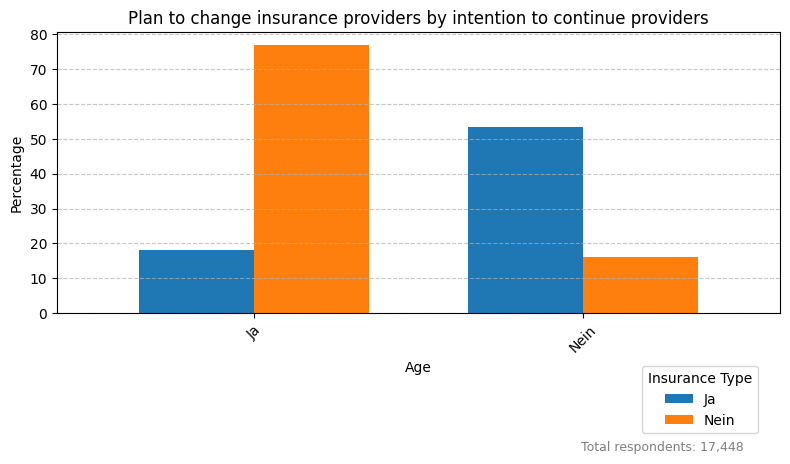

In [55]:
df_combined = flattened_table_q4[
    (flattened_table_q4["Antwortoption"].isin(["Ja", "Nein"])) &
    (flattened_table_q4["Demographic Type"] == "Wiederwahlabsicht") &
    (~flattened_table_q4["Demographic Group"].str.lower().str.contains("evtl"))
]

df_pivot = df_combined.pivot(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)"
).sort_index()

# Plot
ax = df_pivot.plot(kind="bar", figsize=(8, 5), width=0.7)

plt.title("Plan to change insurance providers by intention to continue providers")
plt.ylabel("Percentage")
plt.xlabel("Age")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(
    title="Insurance Type",
    loc="lower left",
    bbox_to_anchor=(0.8, -0.45),
    # ncol=2
)
plt.tight_layout()

plt.text(
    0.95,
    -0.50,
    "Total respondents: 17,448",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.show()

In [59]:
flattened_table_gender = flatten_survey_block(
    file_path="Kundenmonitor_Questions_Summary.xlsx",
    sheet_name="Kundenmonitor_Gender",
    response_rows_keep=[
        "Männlich",
        "Weiblich"
    ],
    total_row_name="n gesamt (gewichtet)"
)

flattened_table_gender.head(5000)

,Question,Demographic Type,Demographic Group,Antwortoption,Value (%),Total,Count
0,Ihr Geschlecht?,Geschlecht,Männlich,Männlich,100.0,8155,8155
1,Ihr Geschlecht?,Geschlecht,Männlich,Weiblich,0.0,8155,0
2,Ihr Geschlecht?,Geschlecht,Weiblich,Männlich,0.0,9314,0
3,Ihr Geschlecht?,Geschlecht,Weiblich,Weiblich,100.0,9314,9314
4,Ihr Geschlecht?,Alter,16-29 Jahre,Männlich,48.3,3172,1532
...,...,...,...,...,...,...,...
143,Ihr Geschlecht?,Zusatzbeitrag,"textless 1,6%",Weiblich,53.1,11191,5942
144,Ihr Geschlecht?,Zusatzbeitrag,"1,6%",Männlich,48.3,2569,1241
145,Ihr Geschlecht?,Zusatzbeitrag,"1,6%",Weiblich,51.3,2569,1318
146,Ihr Geschlecht?,Zusatzbeitrag,"> 1,6%",Männlich,45.6,3546,1617


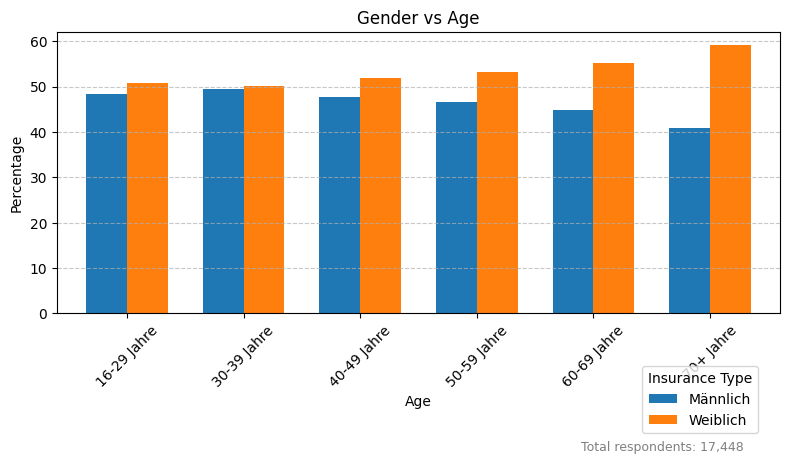

In [60]:
df_combined = flattened_table_gender[
    (flattened_table_gender["Antwortoption"].isin(["Männlich", "Weiblich"])) &
    (flattened_table_gender["Demographic Type"] == "Alter")
]

df_pivot = df_combined.pivot(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)"
).sort_index()

# Plot
ax = df_pivot.plot(kind="bar", figsize=(8, 5), width=0.7)

plt.title("Gender vs Age")
plt.ylabel("Percentage")
plt.xlabel("Age")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(
    title="Insurance Type",
    loc="lower left",
    bbox_to_anchor=(0.8, -0.45),
    # ncol=2
)
plt.tight_layout()

plt.text(
    0.95,
    -0.50,
    "Total respondents: 17,448",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.show()

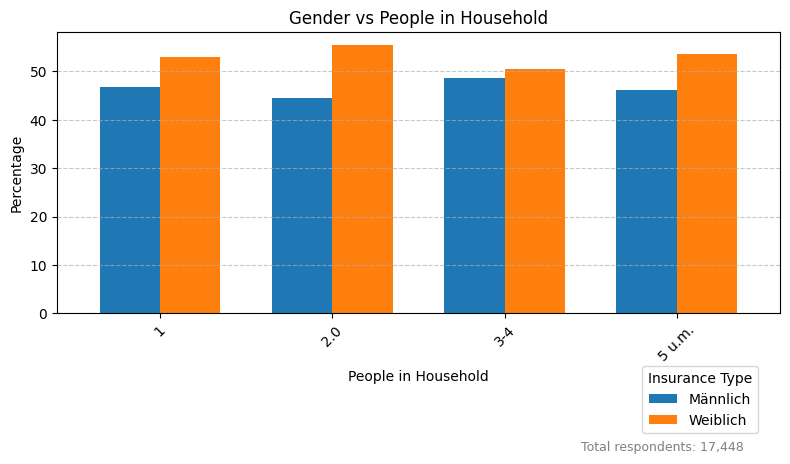

In [62]:
df_combined = flattened_table_gender[
    (flattened_table_gender["Antwortoption"].isin(["Männlich", "Weiblich"])) &
    (flattened_table_gender["Demographic Type"] == "Personen im Haushalt")
]

df_pivot = df_combined.pivot(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)"
).sort_index()

# Plot
ax = df_pivot.plot(kind="bar", figsize=(8, 5), width=0.7)

plt.title("Gender vs People in Household")
plt.ylabel("Percentage")
plt.xlabel("People in Household")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(
    title="Insurance Type",
    loc="lower left",
    bbox_to_anchor=(0.8, -0.45),
    # ncol=2
)
plt.tight_layout()

plt.text(
    0.95,
    -0.50,
    "Total respondents: 17,448",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.show()

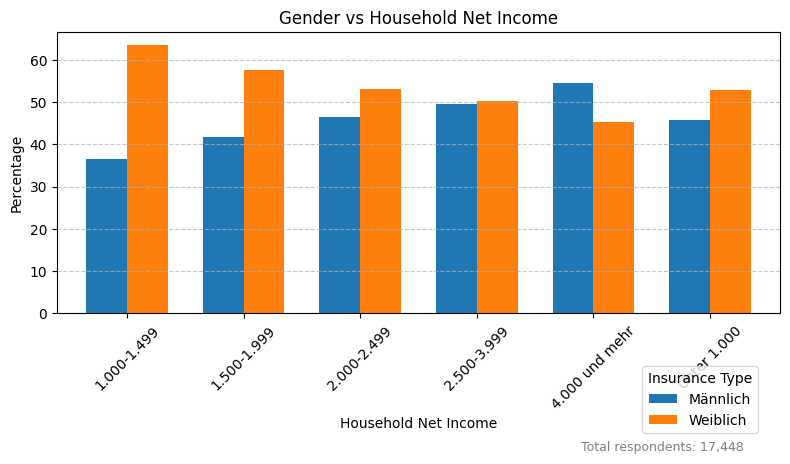

In [63]:
df_combined = flattened_table_gender[
    (flattened_table_gender["Antwortoption"].isin(["Männlich", "Weiblich"])) &
    (flattened_table_gender["Demographic Type"] == "Haushaltsnettoeinkommen in Euro")
]

df_pivot = df_combined.pivot(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)"
).sort_index()

# Plot
ax = df_pivot.plot(kind="bar", figsize=(8, 5), width=0.7)

plt.title("Gender vs Household Net Income")
plt.ylabel("Percentage")
plt.xlabel("Household Net Income")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(
    title="Insurance Type",
    loc="lower left",
    bbox_to_anchor=(0.8, -0.45),
    # ncol=2
)
plt.tight_layout()

plt.text(
    0.95,
    -0.50,
    "Total respondents: 17,448",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.show()

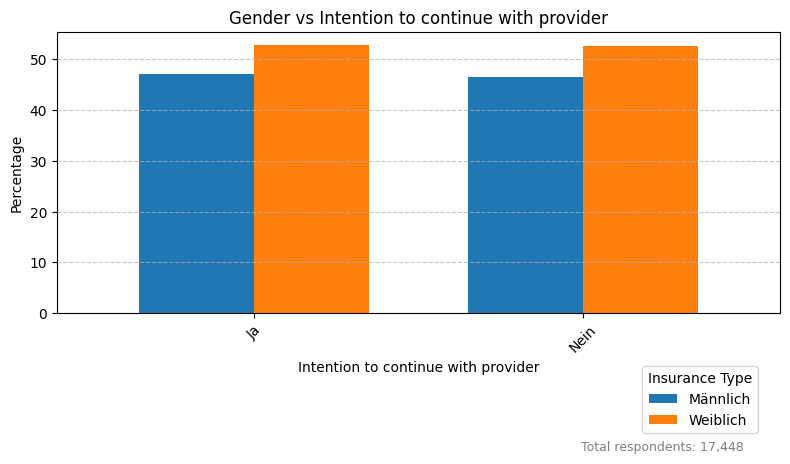

In [80]:
df_combined = flattened_table_gender[
    (flattened_table_gender["Antwortoption"].isin(["Männlich", "Weiblich"])) &
    (flattened_table_gender["Demographic Type"] == "Wiederwahlabsicht") &
    (~flattened_table_gender["Demographic Group"].str.lower().str.contains("evtl"))
]

df_pivot = df_combined.pivot(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)"
).sort_index()

# Plot
ax = df_pivot.plot(kind="bar", figsize=(8, 5), width=0.7)

plt.title("Gender vs Intention to continue with provider")
plt.ylabel("Percentage")
plt.xlabel("Intention to continue with provider")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(
    title="Insurance Type",
    loc="lower left",
    bbox_to_anchor=(0.8, -0.45),
    # ncol=2
)
plt.tight_layout()

plt.text(
    0.95,
    -0.50,
    "Total respondents: 17,448",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.show()

In [65]:
flattened_table_age = flatten_survey_block(
    file_path="Kundenmonitor_Questions_Summary.xlsx",
    sheet_name="Kundenmonitor_Age",
    response_rows_keep=[
        "16 bis 29 Jahre",
        "30 bis 39 Jahre",
        "40 bis 49 Jahre",
        "50 bis 59 Jahre",
        "60 bis 69 Jahre",
        "70+ Jahre"
    ],
    total_row_name="n gesamt (gewichtet)"
)

flattened_table_age.head(5000)

,Question,Demographic Type,Demographic Group,Antwortoption,Value (%),Total,Count
0,Wie alt sind Sie?,Geschlecht,Männlich,16 bis 29 Jahre,18.8,8155,1533
1,Wie alt sind Sie?,Geschlecht,Männlich,30 bis 39 Jahre,17.3,8155,1411
2,Wie alt sind Sie?,Geschlecht,Männlich,40 bis 49 Jahre,15.2,8155,1240
3,Wie alt sind Sie?,Geschlecht,Männlich,50 bis 59 Jahre,21.1,8155,1721
4,Wie alt sind Sie?,Geschlecht,Männlich,60 bis 69 Jahre,17.6,8155,1435
...,...,...,...,...,...,...,...
439,Wie alt sind Sie?,Zusatzbeitrag,"> 1,6%",30 bis 39 Jahre,16.6,3546,589
440,Wie alt sind Sie?,Zusatzbeitrag,"> 1,6%",40 bis 49 Jahre,13.8,3546,489
441,Wie alt sind Sie?,Zusatzbeitrag,"> 1,6%",50 bis 59 Jahre,20.6,3546,730
442,Wie alt sind Sie?,Zusatzbeitrag,"> 1,6%",60 bis 69 Jahre,18.1,3546,642


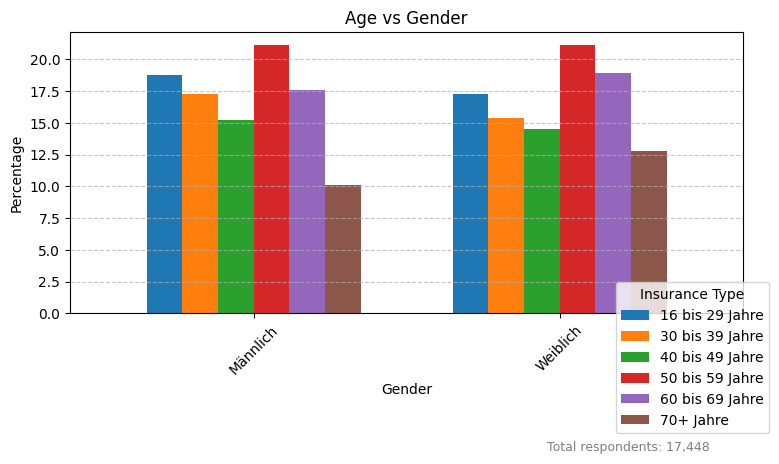

In [66]:
df_combined = flattened_table_age[
    (flattened_table_age["Antwortoption"].isin(["16 bis 29 Jahre",
        "30 bis 39 Jahre",
        "40 bis 49 Jahre",
        "50 bis 59 Jahre",
        "60 bis 69 Jahre",
        "70+ Jahre"])) &
    (flattened_table_age["Demographic Type"] == "Geschlecht")
]

df_pivot = df_combined.pivot(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)"
).sort_index()

# Plot
ax = df_pivot.plot(kind="bar", figsize=(8, 5), width=0.7)

plt.title("Age vs Gender")
plt.ylabel("Percentage")
plt.xlabel("Gender")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(
    title="Insurance Type",
    loc="lower left",
    bbox_to_anchor=(0.8, -0.45),
    # ncol=2
)
plt.tight_layout()

plt.text(
    0.95,
    -0.50,
    "Total respondents: 17,536",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.show()

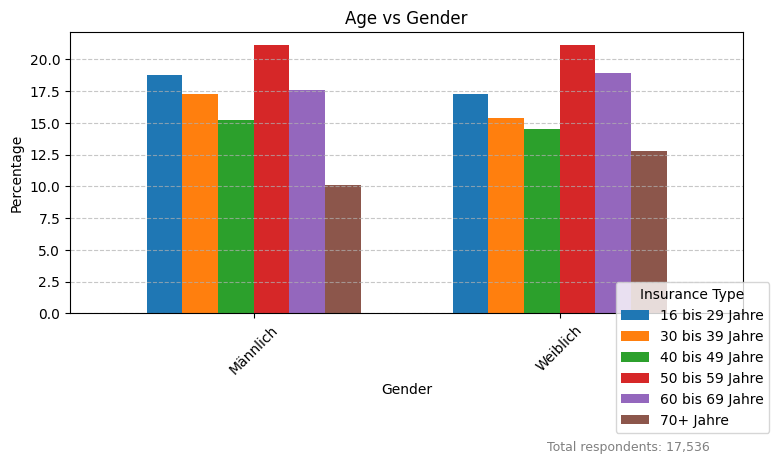

In [68]:
df_combined = flattened_table_age[
    (flattened_table_age["Antwortoption"].isin(["16 bis 29 Jahre",
        "30 bis 39 Jahre",
        "40 bis 49 Jahre",
        "50 bis 59 Jahre",
        "60 bis 69 Jahre",
        "70+ Jahre"])) &
    (flattened_table_age["Demographic Type"] == "Geschlecht")
]

df_pivot = df_combined.pivot(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)"
).sort_index()

# Plot
ax = df_pivot.plot(kind="bar", figsize=(8, 5), width=0.7)

plt.title("Age vs Gender")
plt.ylabel("Percentage")
plt.xlabel("Gender")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(
    title="Insurance Type",
    loc="lower left",
    bbox_to_anchor=(0.8, -0.45),
    # ncol=2
)
plt.tight_layout()

plt.text(
    0.95,
    -0.50,
    "Total respondents: 17,536",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.show()

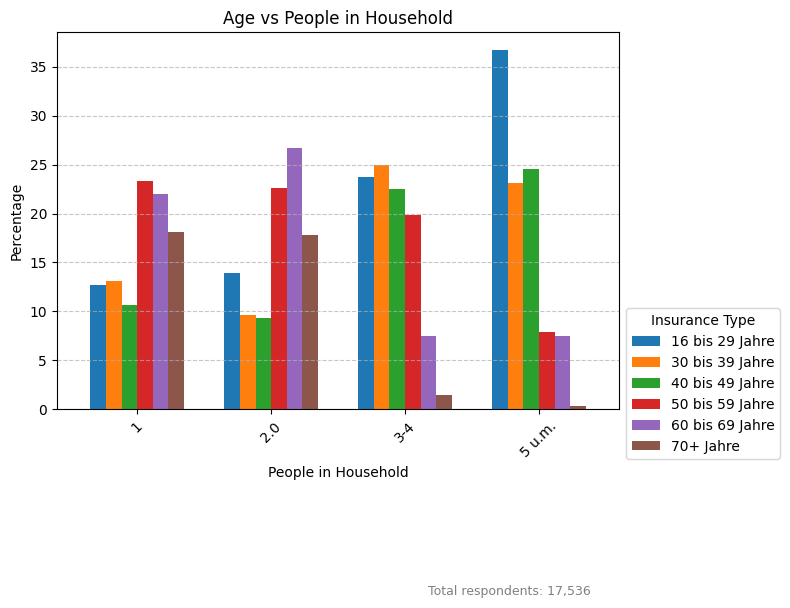

In [75]:
df_combined = flattened_table_age[
    (flattened_table_age["Antwortoption"].isin(["16 bis 29 Jahre",
        "30 bis 39 Jahre",
        "40 bis 49 Jahre",
        "50 bis 59 Jahre",
        "60 bis 69 Jahre",
        "70+ Jahre"])) &
    (flattened_table_age["Demographic Type"] == "Personen im Haushalt")
]

df_pivot = df_combined.pivot(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)"
).sort_index()

# Plot
ax = df_pivot.plot(kind="bar", figsize=(8, 5), width=0.7)

plt.title("Age vs People in Household")
plt.ylabel("Percentage")
plt.xlabel("People in Household")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(
    title="Insurance Type",
    loc="lower left",
    bbox_to_anchor=(1, -0.15),
    # ncol=2
)
plt.tight_layout()

plt.text(
    0.95,
    -0.50,
    "Total respondents: 17,536",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.show()

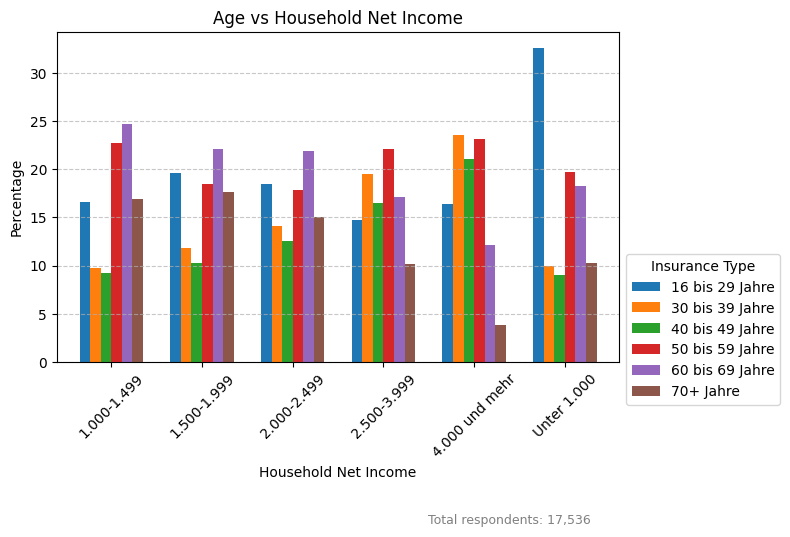

In [77]:
df_combined = flattened_table_age[
    (flattened_table_age["Antwortoption"].isin(["16 bis 29 Jahre",
        "30 bis 39 Jahre",
        "40 bis 49 Jahre",
        "50 bis 59 Jahre",
        "60 bis 69 Jahre",
        "70+ Jahre"])) &
    (flattened_table_age["Demographic Type"] == "Haushaltsnettoeinkommen in Euro")
]

df_pivot = df_combined.pivot(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)"
).sort_index()

# Plot
ax = df_pivot.plot(kind="bar", figsize=(8, 5), width=0.7)

plt.title("Age vs Household Net Income")
plt.ylabel("Percentage")
plt.xlabel("Household Net Income")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(
    title="Insurance Type",
    loc="lower left",
    bbox_to_anchor=(1, -0.15),
    # ncol=2
)
plt.tight_layout()

plt.text(
    0.95,
    -0.50,
    "Total respondents: 17,536",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.show()

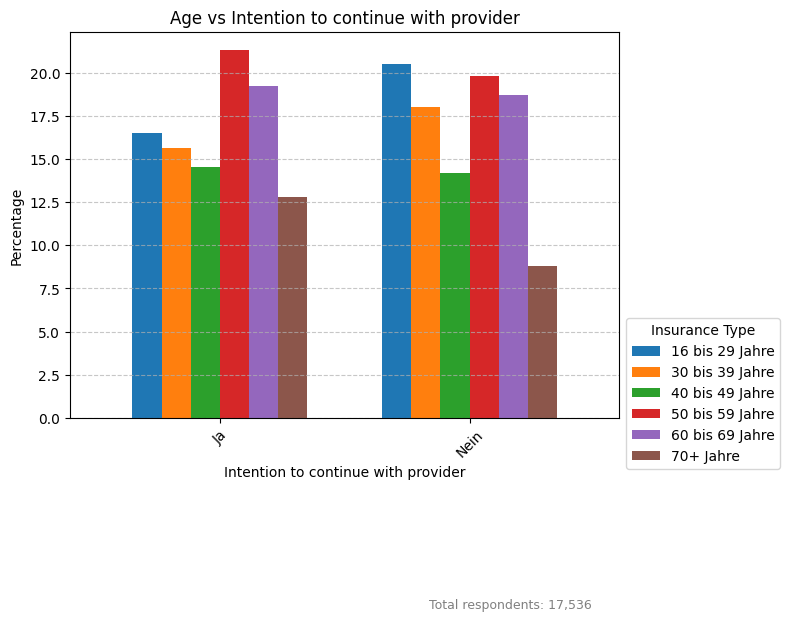

In [79]:
df_combined = flattened_table_age[
    (flattened_table_age["Antwortoption"].isin(["16 bis 29 Jahre",
        "30 bis 39 Jahre",
        "40 bis 49 Jahre",
        "50 bis 59 Jahre",
        "60 bis 69 Jahre",
        "70+ Jahre"])) &
    (flattened_table_age["Demographic Type"] == "Wiederwahlabsicht") &
    (~flattened_table_age["Demographic Group"].str.lower().str.contains("evtl"))
]

df_pivot = df_combined.pivot(
    index="Demographic Group",
    columns="Antwortoption",
    values="Value (%)"
).sort_index()

# Plot
ax = df_pivot.plot(kind="bar", figsize=(8, 5), width=0.7)

plt.title("Age vs Intention to continue with provider")
plt.ylabel("Percentage")
plt.xlabel("Intention to continue with provider")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(
    title="Insurance Type",
    loc="lower left",
    bbox_to_anchor=(1, -0.15),
    # ncol=2
)
plt.tight_layout()

plt.text(
    0.95,
    -0.50,
    "Total respondents: 17,536",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='right',
    va='bottom',
    color='gray'
)

plt.show()